## Get the Data

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("../datasets/housing.tgz")

    if not tarball_path.is_file:
        Path("../datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)

        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="../datasets")

    return pd.read_csv(Path("../datasets/housing/housing.csv"))

housing = load_housing_data()            

## Take a Quick Look at the Data Structure

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


*Extra code: function to save figures in the folder `images`*

In [6]:
IMAGES_PATH = Path() / ".." / "images" / "chapter02"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id: str, tight_layout: bool = True, fig_extension: str = "png", resolution: int = 300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if(tight_layout):
        plt.tight_layout()

    plt.savefig(path, format=fig_extension, dpi=resolution)    

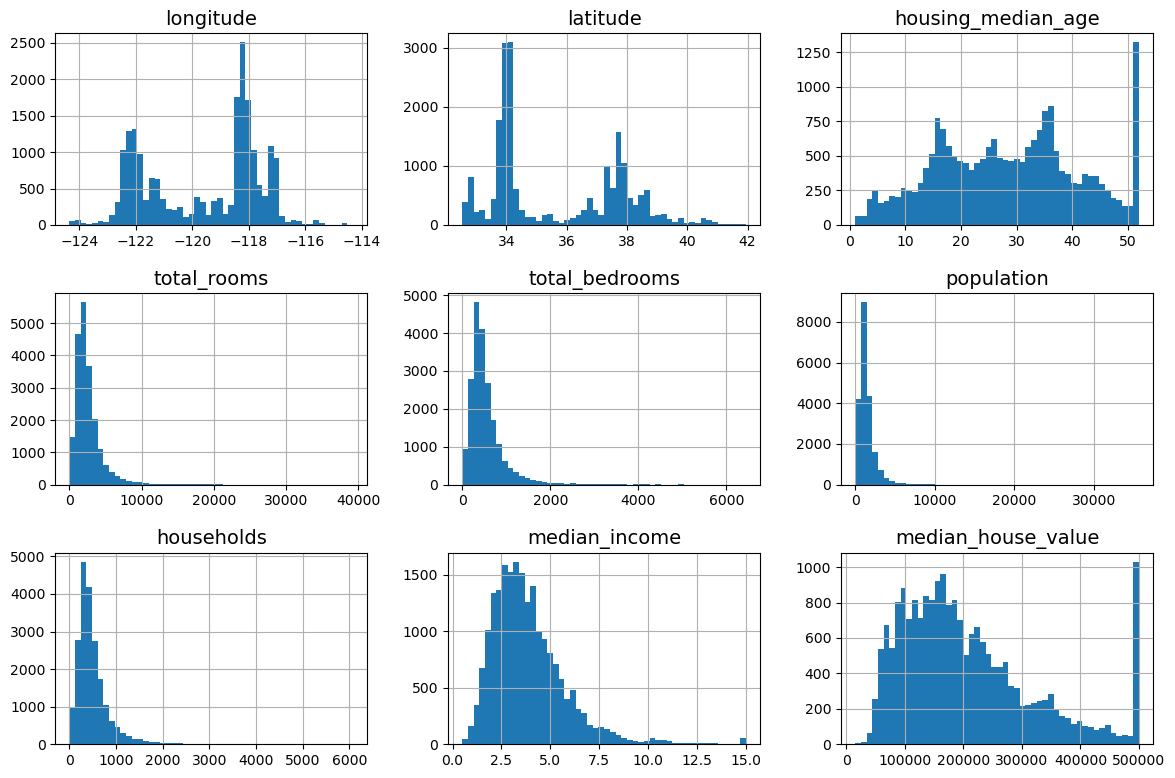

In [7]:
import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")
plt.show()

## Create a Test Set

In [8]:
type(housing)

pandas.core.frame.DataFrame

In [9]:
import numpy as np

def shuffle_and_split_data(data: pd.DataFrame, test_ratio: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

To ensure that the random output remain the same every time we run it, we need to set the random seed:

In [12]:
np.random.seed(42)

However, both these solutions will break the next time you fetch an updated dataset. 

To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have unique and immutable identifiers). 

For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. 

This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [13]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio: float):
    return crc32(np.int64(identifier)) < test_ratio * 2**32 ## hash function to produce a 32-bit hash value

def split_data_with_id_hash(data: pd.DataFrame, test_ratio: float, id_column: str):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set] # returns 2 DataFrames, one where in_test_set=False, one where in_test_set=True

In [14]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset and that no row ever gets deleted.

If this is not possible, then you can try to use the most stable features to build a unique identifier.

For example, a district's latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID.

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

**Using Scikit-learn:**

In [16]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [17]:
test_set["total_bedrooms"].isnull().sum()

44

**BONUS**

To find the probability that a randome sample of 1000 people contains less than 48.5% female or more than 53.5% female when the population's female ratio is 51.5%, we use the **binomial distribution**. 

The `cdf()` method of the binomial distribution gives us the probability that the number of females will be equal or less than the given value.

In [18]:
from scipy.stats import binom

sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485 - 1)
proba_too_large = 1 - binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.10736798530929942


Another way to estimate the probability of bad sample

In [19]:
np.random.seed(42)

samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis=1)

((samples < 485) | (samples > 535)).sum()

10710

The following code uses the `pd.cut()` function to create an income category attribute with five categories (labeled from 1 to 5)

Category 1 ranges from 0 to 1.5 (i.e., less than $15000)

Category 2 from 1.5 to 3

And so on:

In [20]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

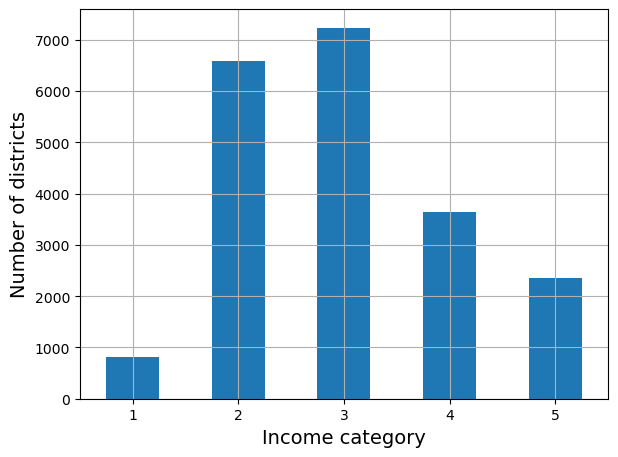

In [21]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

Generate 10 different stratified splits of the same dataset:

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []

for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [23]:
strat_train_set, strat_test_set = strat_splits[0]

It's much shorter to get a single stratified split:

In [24]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42
)

In [25]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

To compute the sampling bias comparison of stratified versus purely random sampling:

In [26]:
def income_cat_proportions(data: pd.DataFrame):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set)
}).sort_index()

compare_props.index.name = "Income Category"
compare_props["Strat. Error %"] = (compare_props["Stratified %"] / compare_props["Overall %"] - 1)
compare_props["Rand. Error %"] = (compare_props["Random %"] / compare_props["Overall %"] - 1) 

(compare_props * 100).round(2)

,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [27]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [28]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

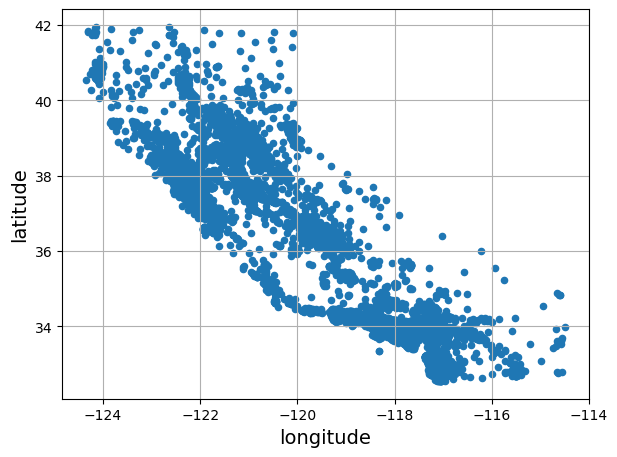

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig("bad_visualization_plot")
plt.show()

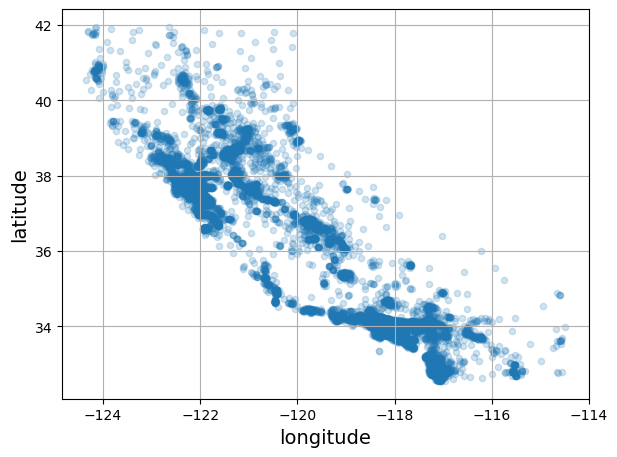

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
save_fig("better_visualization_plot")
plt.show()

The following plot: 

The radius of each circle represents the district's population(option `s`),

and the color represents the price(option `c`).

Here you use a predefined color map (option `cmap`) called `jet`, which ranges from blue(low values) to red (high prices)

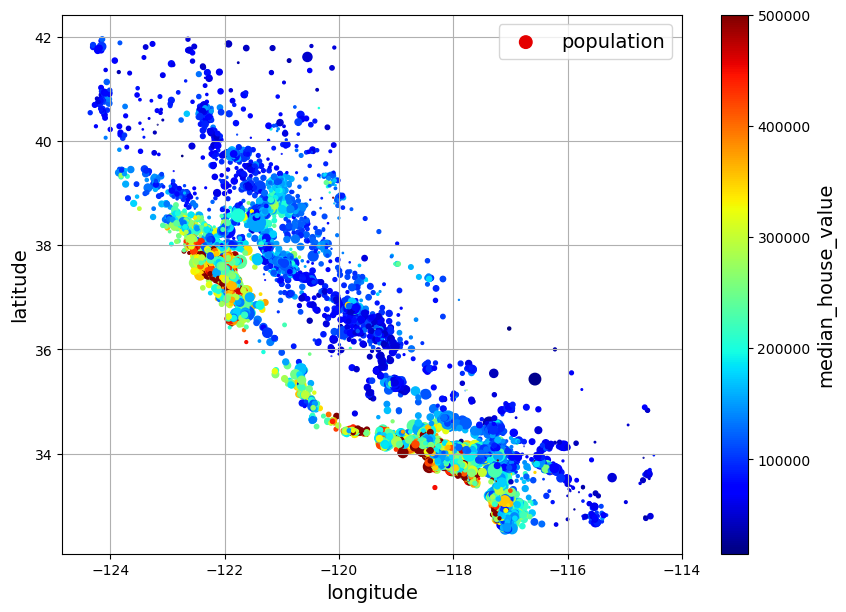

In [31]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
# save_fig("housing_prices_scatterplot")
plt.show()

More beautiful version with an image of California added in the background, nicer label names and no grid.

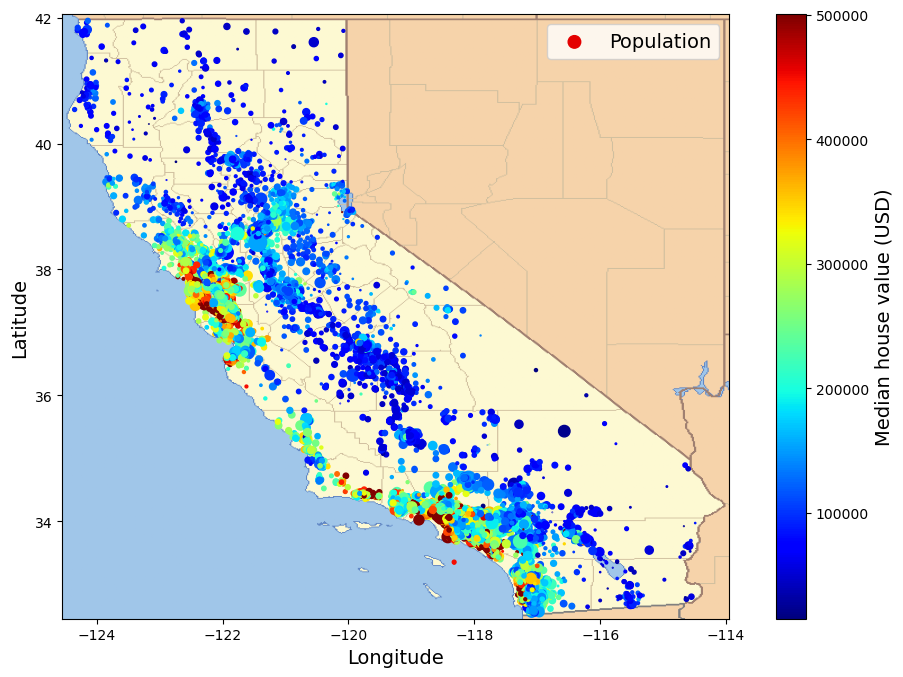

In [32]:
# Download the California image
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude",
    "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"
})
housing_renamed.plot(
    kind="scatter", x="Longitude", y="Latitude",
    s=housing_renamed["Population"] / 100, label="Population",
    c="Median house value (USD)", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7)
)

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()

## Looking for Correlations

In [33]:
corr_matrix = housing.corr(numeric_only=True)

In [34]:
corr_matrix["median_house_value"].sort_values(ascending=True)

latitude             -0.139584
longitude            -0.050859
population           -0.020153
total_bedrooms        0.054635
households            0.071426
housing_median_age    0.102175
total_rooms           0.137455
median_income         0.688380
median_house_value    1.000000
Name: median_house_value, dtype: float64

Another way to check for correlation between attributes is to use Pandas `scatter_matrix()` function, which plots every numerical attribute against every other numerical attribute.

Since there are now 11 numerical attributes, you would get 11**2 = 121 plots, which would not fit on a page - so you decide to focus on a few promising attributes that seem most correlated with the median housing value

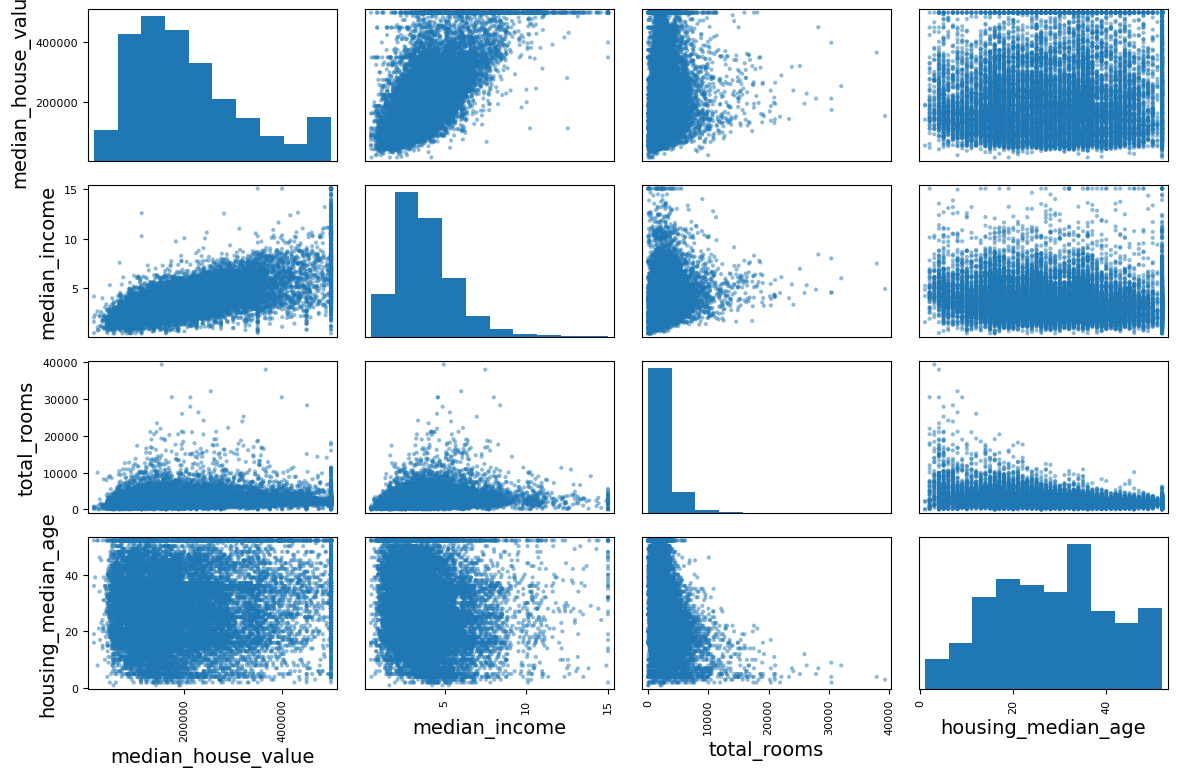

In [35]:
from pandas.plotting import scatter_matrix

attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age"
]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")
plt.show()

Zoom on the correlation between `median_house_value` and `median_income`:

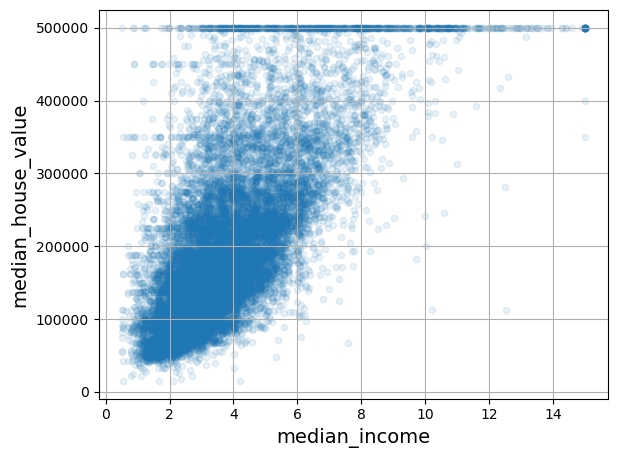

In [36]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")
plt.show()

This plot reveals a few things.

First, the correlation is indeed quite strong: 
- Upward trend
- Points are not too dispersed

Second, the price cap you noticed earlier is clearly visible as a horizontal line at $500,000.

The plot also reveals other less obvious straight lines: 
- A horizontal line around $450,000
- Another around $350,000
- Perhaps one around $280,000
- And a few more below that

You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

# Experimenting with Attribute Combinations

### Key Takeaways from Data Exploration

- **Data Cleaning:** Unusual or inconsistent data points (quirks) need to be fixed before using the data for machine learning.

- **Identifying Relationships:**  Interesting connections (correlations) have been found between different data characteristics, especially with the target attribute (the thing we're trying to predict).

- **Addressing Skewed Data:** Some attributes have many values bunched on one end and a long tail on the other (skewed-right distribution). This might need adjustment (e.g., using logarithms or square roots) before further analysis.

---
**General Idea:**

While each data analysis project is unique, the overall process of exploring, finding patterns, and preparing data for analysis follows a similar path. 


### Exploring Attribute Combinations

One final step before preparing data for machine learning is to experiment with combining attributes.  For example:

- **Rooms per Household:** Combining "total rooms" with "households" to create a more meaningful metric.
- **Bedrooms per Room:** Comparing "total bedrooms" to "total rooms" to understand the bedroom-to-room ratio.
- **Population per Household:**  Examining "population" relative to "households" for insights into household size.

These new attributes are created as follows: 


In [37]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

And then you look at the correlation matrix again:

In [38]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

### Insights from New Attributes

- **Bedrooms per Room:** The `bedrooms_ratio` attribute shows a stronger correlation with median house value than the raw counts of bedrooms or total rooms. Houses with fewer bedrooms per room tend to be more expensive.

- **Rooms per Household:** This metric is more informative than the total number of rooms in a district. Larger houses, with more rooms per household, are generally associated with higher prices.


# Prepare the Data for Machine Learning Algorithms

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [39]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Data Cleaning

In the book 3 options are listed to handle the NaN values:

```python
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

For each option, we'll create a copy of `housing` and work on that copy to avoid breaking `housing`. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [40]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


### Let's try all 3 options:

Option 1:

In [42]:
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


Option 2:

In [43]:
housing_option2 = housing.copy()
housing_option2.drop("total_bedrooms", axis=1, inplace=True)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


Option 3:

In [45]:
housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)

housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


### Handling Missing Values with SimpleImputer

For handling missing values, we'll use Scikit-Learn's `SimpleImputer`:

- **Less Destructive:** This method is the least disruptive to the existing data.

- **Stores Median Values:** The imputer will save the median value for each attribute, making it reusable for future data sets (validation, test, and new data).

**How to Use:**

1. **Create an instance:** Instantiate the `SimpleImputer`, specifying that missing values should be replaced with the median.


In [46]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [47]:
housing_num = housing.select_dtypes(include=[np.number])

Now you can fit the `imputer` instance to the training data using the `fit()` method:

In [48]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

### Imputing Missing Values

- **Median Imputation:** The `SimpleImputer` calculated and stored the median value for each attribute in its `statistics_` variable. 

- **Applying to All Numerical Attributes:** Although only `total_bedrooms` had missing values in this dataset, it's safer to apply the imputer to all numerical attributes to handle potential missing data in the future.


In [49]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Check that this is the same as manually computing the median of each attribute:

In [50]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now you can use this "trained" `imputer` to transform the training set by replacing missing values with the learned medians:

In [51]:
X = imputer.transform(housing_num)

In [52]:
X

array([[-1.2242e+02,  3.7800e+01,  5.2000e+01, ...,  1.5760e+03,
         1.0340e+03,  2.0987e+00],
       [-1.1838e+02,  3.4140e+01,  4.0000e+01, ...,  6.6600e+02,
         3.5700e+02,  6.0876e+00],
       [-1.2198e+02,  3.8360e+01,  3.3000e+01, ...,  5.6200e+02,
         2.0300e+02,  2.4330e+00],
       ...,
       [-1.1706e+02,  3.2590e+01,  1.3000e+01, ...,  2.8140e+03,
         7.6000e+02,  4.0616e+00],
       [-1.1840e+02,  3.4060e+01,  3.7000e+01, ...,  1.7250e+03,
         8.3800e+02,  4.1455e+00],
       [-1.2241e+02,  3.7660e+01,  4.4000e+01, ...,  6.8200e+02,
         2.1200e+02,  3.2833e+00]])

### Output Format from Scikit-Learn Transformers

- **NumPy Arrays:** Scikit-Learn transformers typically output NumPy arrays (or sometimes SciPy sparse matrices), even when the input is a Pandas DataFrame.

- **Loss of Column Names and Index:**  After applying the `imputer.transform(housing_num)`, the resulting array `X` lacks column names and index information.

- **Recovering Information:** We can wrap the `X` array back into a DataFrame and restore the column names and index from the original `housing_num` DataFrame. 


In [53]:
housing_tr = pd.DataFrame(
    X,
    columns=housing_num.columns,
    index=housing_num.index
)

In [54]:
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


# Handling Text and Categorical Attributes

Let's prepocess the categorical input feature, `ocean_proximity`:

In [56]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

### Encoding Categorical Attributes

- **Limited Categories:** The `ocean_proximity` attribute is categorical, meaning it has a fixed set of possible values, each representing a distinct category.

- **Converting to Numbers:** Most machine learning algorithms work best with numerical data. We'll use Scikit-Learn's `OrdinalEncoder` to convert these text categories into numerical representations.


In [57]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [58]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [61]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### One-Hot Encoding for Categorical Data

- **Issue with Ordinal Encoding:** Machine learning algorithms might incorrectly assume that numerically close categories are more similar. This doesn't apply to our `ocean_proximity` attribute.

- **One-Hot Encoding Solution:** Create one binary attribute (0 or 1) for each category. Only one attribute will be "hot" (1) at a time, indicating the presence of that specific category.

- **Dummy Attributes:** These new binary attributes are sometimes called dummy attributes.

- **Scikit-Learn's OneHotEncoder:** This class can convert categorical values into one-hot vectors, providing a suitable representation for machine learning algorithms.


In [63]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [64]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### Sparse Matrices in Scikit-Learn

- **Sparse Matrix Representation:** Sparse matrices are a very efficient way to represent matrices that mostly contain zeros. Internally, they store only the non-zero values and their positions.

- **One-Hot Encoding and Sparse Matrices:**  One-hot encoding categorical attributes with many categories often results in a large matrix full of zeros. Sparse matrices are the perfect solution in this scenario, saving memory and speeding up calculations.

- **Using Sparse Matrices:** You can generally use sparse matrices like regular 2D arrays.

- **Converting to Dense Arrays:** If you need a dense NumPy array, call the `toarray()` method on the sparse matrix.


In [ ]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Alternatively, you can set `sparse_output=False` when creating the `OneHotEncoder` (note: the `sparse` hyperparameter was renamned to `sparse_output` in Scikit-Learn 1.2):

In [67]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [68]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pandas has a function called `get_dummies()`, which also converts each categorical feature into a one-hot representation, with one binary feature per category:

In [73]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [74]:
cat_encoder.transform(df_test)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [75]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [76]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

### Feature Names and Estimators in Scikit-Learn

- **Storing Column Names:** When fitting a Scikit-Learn estimator with a DataFrame, the estimator stores the column names in its `feature_names_in_` attribute.

- **Ensuring Consistent Column Names:** Scikit-Learn checks that any DataFrame fed to this estimator after that (e.g., to `transform()` or `predict()`) has the same column names.

- **Retrieving Feature Names:** Transformers also provide a `get_feature_names_out()` method that you can use to build a DataFrame around the transformer's output.


In [77]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [78]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [79]:
df_output = pd.DataFrame(
    cat_encoder.transform(df_test_unknown),
    columns=cat_encoder.get_feature_names_out(),
    index=df_test_unknown.index
)

In [80]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


# Feature Scaling